<a href="https://colab.research.google.com/github/stephanyvargas/DataAnalysis-Public/blob/master/DroopMadeEasy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Characterization of the Droop effect

The IceCube experiment is preparing the next generation of detectors that will be burried at the South Pole in the season 2023/2025. These detectors are been built at Chiba University with the help from institutions all over the world. Each detector will use two High Voltage Boards (HVBs) to power the detectors, but these HVBs have a droop effect that needs to be characterized before deployement. 

* **Signal of the detector**

The ouput signal of a detector consists of an *AC* (Alternating Current) signal with the *High Voltage DC* (Direct Current) signal. The *AC* signal has the information that researches are interested in: black hole mergers, supernova explosions, solar physics and more astrophysical processes. The *High Voltage DC* signal corresponds to the electric input that is needed to power the detector device. 

* **Use of a toroid to filter the signal**

The HVBs use a toroidal transformer as a high pass filter, that means that it will filter out the *High Voltage DC* signal before it goes into the main board. This is because if the *High Voltage DC* signal goes direcly into the main board, it will burn the sensible electronics in the main board.

* **Problem**

The use of a toroidal transformer deforms the *AC* signal in an effect known as droop. This means that the top part of the pulse loses amplitude and the baseline is deformed. The deformation of the *AC* signal means that the  astrophysics process that we are interested in studying would have large uncertainties. Therefore, the need to correct these effect.

We also have that the deformation is temperature dependent and gets worst at lower temperatures. This is particular important since these detectors will be burried at the South Pole, and we expect them to work between temperatures -20$^\circ$C to -45$^\circ$C.

* **Goal**

Recover the original form of a drooped signal using two different methods: Chris's method (recurring algorithm method devoloped by a professor in America)and Stephany's method (my own methodology of obtaining the reconstruction.)

The **original signal to recover is an square pulse** that comes from a function generator as a step pulse.


#For this notebook

The code that comes next, analyzes an small portion of the data. Constants from the database and random data have been prepared in advance.

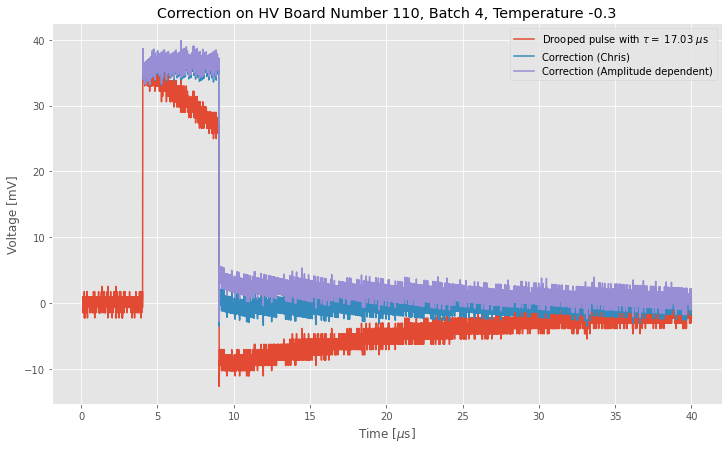

In [ ]:
from matplotlib import pyplot as plt
#from random import randint
#import numpy as np
#import glob
import sys
plt.rcParams.update({'font.size': 13})

'''Load a random Waveform for a given temperature for a given HVB, each measurement has 100 waveforms
This reconstruction is done on an individual measurement. The correction begins at 90% of the pulse height.'''
Batch = 4 
Directory_board = 110 #Random waveform presented here
temp = -0.3 #Exact temperature that was measured

def random_wfcorrection(Batch, Directory_board, Directory_temp):
	random_waveform = 'https://raw.githubusercontent.com/stephanyvargas/DataAnalysis-Public/master/tektronix(0).CSV'
	data = np.loadtxt(fname=random_waveform, delimiter=',', skiprows=25)
	time = data[:,0]
	volt = data[:,1]
	volts = volt - np.mean(volt[0:100])
	dt = np.diff(time)[0]
	mask = volts >= 0.9*max(volts) #begin the reconstruction at 90% of the maximum ->trigger
	droop_trigger = time[mask]
	time_trigger = droop_trigger[0]
	return time, volts, dt, time_trigger

time, volts, dt, time_trigger = random_wfcorrection(Batch, Directory_board, Directory_temp)

#Recover the droop time constant from the temperature and the database values. The time and the tau are in seconds.
p_0 = 2.58013573784
p_1 = 27.02177767276
p_2 = 35.85397584656
p_3 = 2.05136273666
p_4 = 30.07005485862
p_5 = 38.06727359425

#The tau constants are the time constants that characterize the deformation, therefore, the correction is based in recovering these constants.
tau_2 = (p_0 + p_1/(1+np.exp(-temp/p_2)))*1E-6
tau = (p_3 + p_4/(1+np.exp(-temp/p_5)))*1E-6
mask_trigger = time >= time_trigger
Y = volts[mask_trigger]
T = time[mask_trigger]


def chris_correction(tau, dt, Y, T):
    A = (tau/dt) * (1-np.exp(-dt/tau))
    S = 0
    X0 = (1/A * Y[0])
    X = [X0]
    for j in range(1, len(T)):
        sj = X[j-1] + S*np.exp(-dt/tau)
        xj = (1/A) * Y[j] + (A*dt)/tau * sj
        S = sj
        X.append(xj)
    return X

def stephy_correction(tau, dt, Y, T):
    A = np.max(Y)
    B = np.min(Y)
    mask = Y == np.min(Y)
    width = T[mask]

    X = []
    time = T[0]
    j = 0
    #Droop Correction
    while time < width[0]:
        xj = Y[j] + A * (1 - np.exp(-(T[j]-T[0])/tau))
        X.append(xj)
        time = T[j]
        j += 1
    #Undershoot correction
    for i in range(j, len(T)):
        xi = Y[i] - B * (np.exp(-(T[i]-width[0])/tau))
        X.append(xi)
        time = T[i]
    return X

Xc = chris_correction(tau, dt, Y, T)
Xs = stephy_correction(tau, dt, Y, T)

TAU = tau*1E6
Xc = np.asarray(Xc)
Xs = np.asarray(Xs)

theme = 'ggplot'
plt.style.use(theme)
plt.figure(figsize=(12, 7))
plt.title(f'Correction on HV Board Number {Directory_board}, Batch {Batch}, Temperature {temp}')
plt.plot(time*1E6, volts*1000, label=fr'Drooped pulse with $\tau=$ {TAU:.2f} $\mu$s')
plt.plot(T*1E6, Xc*1000, label='Correction (Chris)')
plt.plot(T*1E6, Xs*1000, label='Correction (Amplitude dependent)')
#plt.plot(T*1E6, (Xc/Xs))#, label='Ratio (Chris/Steph)')
#plt.xlim(T[0]*1E6,10)
#plt.ylim(0.9,1.1)
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel('Voltage [mV]')
#plt.ylabel('Ratio (Chris/Steph)')
plt.legend(loc='best')
plt.show()
plt.clf()
plt.cla()
plt.close()

No handles with labels found to put in legend.


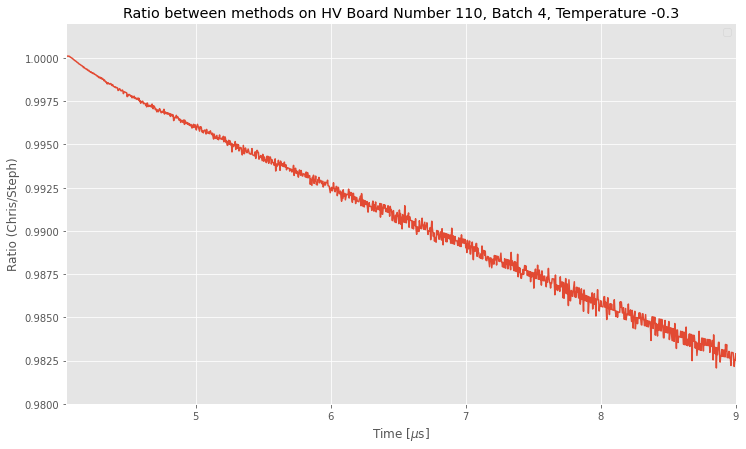

In [ ]:
theme = 'ggplot'
plt.style.use(theme)
plt.figure(figsize=(12, 7))
plt.title(f'Ratio between methods on HV Board Number {Directory_board}, Batch {Batch}, Temperature {temp}')
plt.plot(T*1E6, (Xc/Xs))#, label='Ratio (Chris/Steph)')
plt.xlim(T[0]*1E6,9)
plt.ylim(0.98,1.002)
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel('Ratio (Chris/Steph)')
plt.legend(loc='best')
plt.show()

No handles with labels found to put in legend.


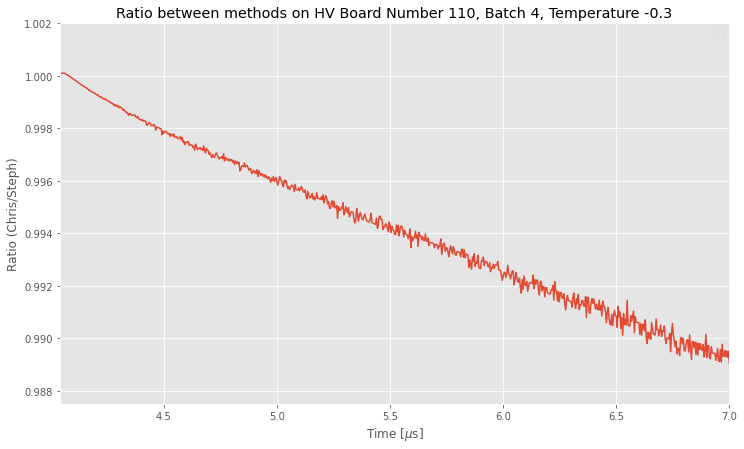

In [ ]:
theme = 'ggplot'
plt.style.use(theme)
plt.figure(figsize=(12, 7))
plt.title(f'Ratio between methods on HV Board Number {Directory_board}, Batch {Batch}, Temperature {temp}')
plt.plot(T*1E6, (Xc/Xs))#, label='Ratio (Chris/Steph)')
plt.xlim(T[0]*1E6,7)
plt.ylim(0.9875,1.002)
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel('Ratio (Chris/Steph)')
plt.legend(loc='best')
plt.show()

#Conclusion
We see that for long signals (longer than 1us), the difference between both methods grow and is up to 2%. The signals that we are expected to get from the detectors are in the range of 100ns up to 3us, then the difference is smaller and tolerable (up to 1.2%).

Then, we can say that the signal was succesfully recovered.

#Outlook
This process is automatized and expected to handle the **650 HVBs** that will be tested before deployment.

Besides this *correction code*, in parallel the *data taking*, the *database construction* and the *analysis codes* are working to get the work flow going.

Some of these information has been made public at

https://github.com/stephanyvargas/DataAnalysis-Public
